# Forecasting the stock distribution of Contraceptives in Côte d'Ivoire


We aim to predict consumption (stock_distributed from "train.csv") for 10 contraceptives across 156 health service delivery sites in the public sector health system in Côte D’Ivore. The predictions should be made monthly for three months (July, August, September from 2019).

We have 5 different datasets:

- **Train.csv**
- **product.csv**
- **service_delivery_site_data.csv**
- **contraceptive_case_data_monthly.csv**
- **contraceptive_case_data_annual.csv**

In this Notebook we will only use 3 datasets:

- **Train.csv**: This dataset has many columns, it contains the target to predict: **stock_distributed** other information as the date, the product_code, the site_code and other variables as the stock ordered that day of the product in the site etc....
- **product.csv**: This dataset maps the product codes to its type of product. For example the product: **AS17005** is a Female Condom.
- **service_delivery_site_data.csv**: This dataset maps the site codes to the type of service, region and district. For example the site code C1399 is a Health Center in Abidjan 2 

## Table of Contents:
* [1. Exploratory Data Analysis](#ExploratoryDataAnalysisandVisualizations)
    * Univariate data Analysis
    * Study time series of products
    * Missing values
    * Seasonality
* [2. Defining Features]()
* [2. Classical Machine Learning approach](#second-bullet)
* [3. Neural Network approach](# third-bullet)

In [1]:
import os
from os import listdir
from os.path import join, dirname
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from datetime import datetime
from tqdm import tqdm

PATH_REPO = dirname(os.getcwd())
PATH_DATA = join(PATH_REPO, 'data')
PATH_UTILS = join(PATH_REPO, 'src')
sys.path.append(PATH_UTILS)

import preprocess
import models_
from models_ import predict_sklearn_pipeline

sns.set(style='whitegrid')

In [2]:
data = pd.read_csv(join(PATH_DATA, 'Train.csv'))
submission_df = pd.read_csv(join(PATH_DATA, 'SampleSubmission.csv'))
submission_df[['year', 'month', 'site_code', 'product_code']] = submission_df['ID'].str.split(' X ', expand=True)
product_data = pd.read_csv(join(PATH_DATA, 'product.csv'))
service_data = pd.read_csv(join(PATH_DATA, 'service_delivery_site_data.csv'))
prodCode2prodType = {code:type for type, code in zip(product_data.loc[:,'product_type'].values, 
                                                product_data.loc[:,'product_code'].values)}

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35753 entries, 0 to 35752
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         35753 non-null  int64  
 1   month                        35753 non-null  int64  
 2   region                       35753 non-null  object 
 3   district                     35753 non-null  object 
 4   site_code                    35753 non-null  object 
 5   product_code                 35753 non-null  object 
 6   stock_initial                35753 non-null  int64  
 7   stock_received               35753 non-null  int64  
 8   stock_distributed            35753 non-null  int64  
 9   stock_adjustment             35753 non-null  int64  
 10  stock_end                    35753 non-null  int64  
 11  average_monthly_consumption  35753 non-null  int64  
 12  stock_stockout_days          35753 non-null  int64  
 13  stock_ordered   

In total there are 14 different variables. 

- *year* and *month* are for the date
- There are 8 numerical continous variables: *stock_ordered, stock_received, stock_distributed, stock_adjustment, stock_end, average_monthly_consumption, stock_stockout_days, stock_ordered*
- There are 4 categorical variables: *region, district, site_code, product_code* 

# 1. Exploratory Data Analysis and Visualizations

### Stock distributed per product

Let's start by understanding the distribution of the stock distributed across the products

In [4]:
product_codes = []
stock_values = []
for product in np.unique(data.loc[:,'product_code']):
    data_product = data.loc[data.loc[:,'product_code']==product, 'stock_distributed'].sum()
    print(f'the total stock distributed for product code {product} and type {prodCode2prodType[product]} is {data_product}')
    product_codes.append(product)
    stock_values.append(data_product)

the total stock distributed for product code AS17005 and type Female Condom is 2104
the total stock distributed for product code AS21126 and type Injectable Contraceptive is 398
the total stock distributed for product code AS27000 and type Oral Contraceptive (Pill) is 158906
the total stock distributed for product code AS27132 and type Oral Contraceptive (Pill) is 23975
the total stock distributed for product code AS27133 and type Injectable Contraceptive is 146777
the total stock distributed for product code AS27134 and type Injectable Contraceptive is 97780
the total stock distributed for product code AS27137 and type Contraceptive Implant is 29787
the total stock distributed for product code AS27138 and type Contraceptive Implant is 26950
the total stock distributed for product code AS27139 and type Emergency Contraceptive (Pill) is 2234
the total stock distributed for product code AS42018 and type Intrauterine Device (IUD) is 560
the total stock distributed for product code AS46000

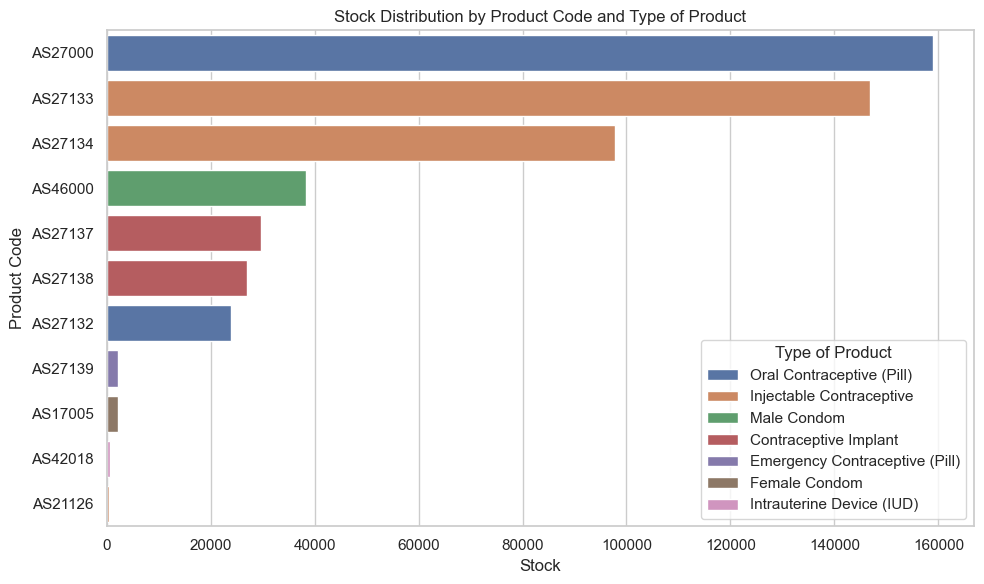

In [5]:

# Create a DataFrame from the data
data_plot = pd.DataFrame({'Product Code': product_codes, 'Type of Product': [prodCode2prodType[product] for product in product_codes], 'Stock': stock_values})
data_plot_sorted = data_plot.sort_values('Stock', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Stock', y='Product Code', hue='Type of Product', data=data_plot_sorted, dodge=False)
plt.xlabel('Stock')
plt.ylabel('Product Code')
plt.title('Stock Distribution by Product Code and Type of Product')
plt.legend(title='Type of Product')

plt.tight_layout()
plt.show()

Comments on plot: 

- The distribution is highly unbalanced
- The Female Condom, IUD and Emergency Pill are rarely consumed by sites
- The Injectable Contraceptive is the most consumed in general. There are 3 codes for this type, 2 are very consumed but there is one code **AS21126** that is almost no distributed, its the code with less consumption. 

#### Stock distributed per region 

In [6]:
## Let's create two dictionnaries one for mapping each site_code to the type of service

servCode2servType = {code:type for code, type in zip(service_data.loc[:,'site_code'].values, 
                                                service_data.loc[:,'site_type'].values)}
district2region = {dis:reg for dis, reg in zip(service_data.loc[:,'site_district'].values, 
                                                service_data.loc[:,'site_region'].values)}


data['service_type'] = data['site_code'].apply(lambda x: servCode2servType[x])



sites = np.unique(data['site_code'])
siteCode2region = {}
siteCode2district = {}
for site in sites:
    siteCode2region[site] = data.loc[data.loc[:,'site_code']==site, 'region'].sample(1).values[0]
    siteCode2district[site] = data.loc[data.loc[:,'site_code']==site, 'district'].sample(1).values[0]

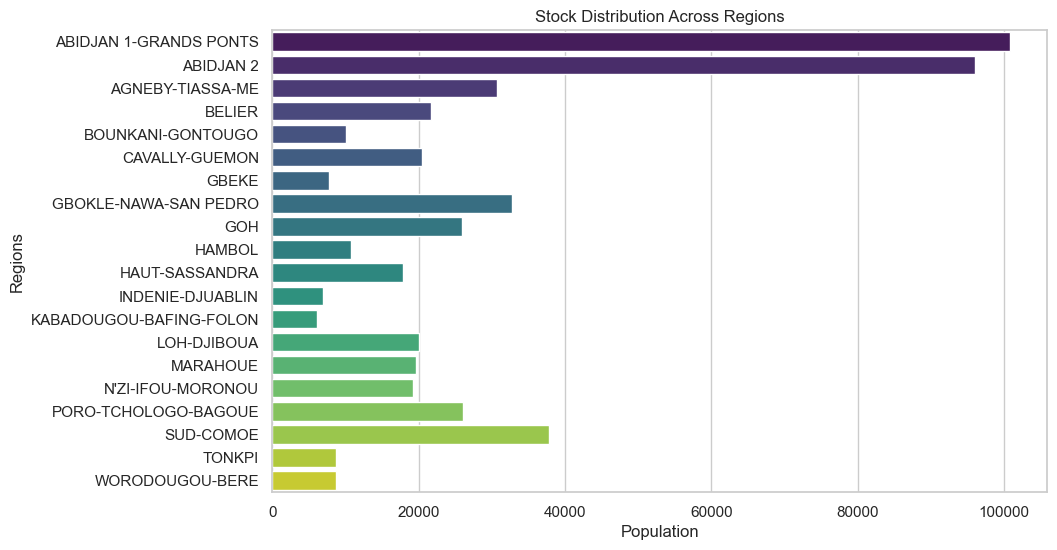

In [7]:
sum_regions = []
for region in np.unique(data.loc[:,'region']):
    sum_regions.append(data.loc[data.loc[:,'region']==region, 'stock_distributed'].sum())

# Set the Seaborn style
sns.set(style='whitegrid')

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sum_regions, y=np.unique(data.loc[:,'region']), palette='viridis')

# Add labels and title
plt.xlabel('Population')
plt.ylabel('Regions')
plt.title('Stock Distribution Across Regions')

# Display the chart
plt.show()

- The distribution is also unbalanced, however it's more uniform than for products.
- It would be great to have access to the population to see if it is proportional to the population of each region
- The region looks like a good variable that give us information of the stock distributed. It is more likely to have more stock distributed in **Abidjan 2** that in **Tonkpi**

### Distribution of Stock per district

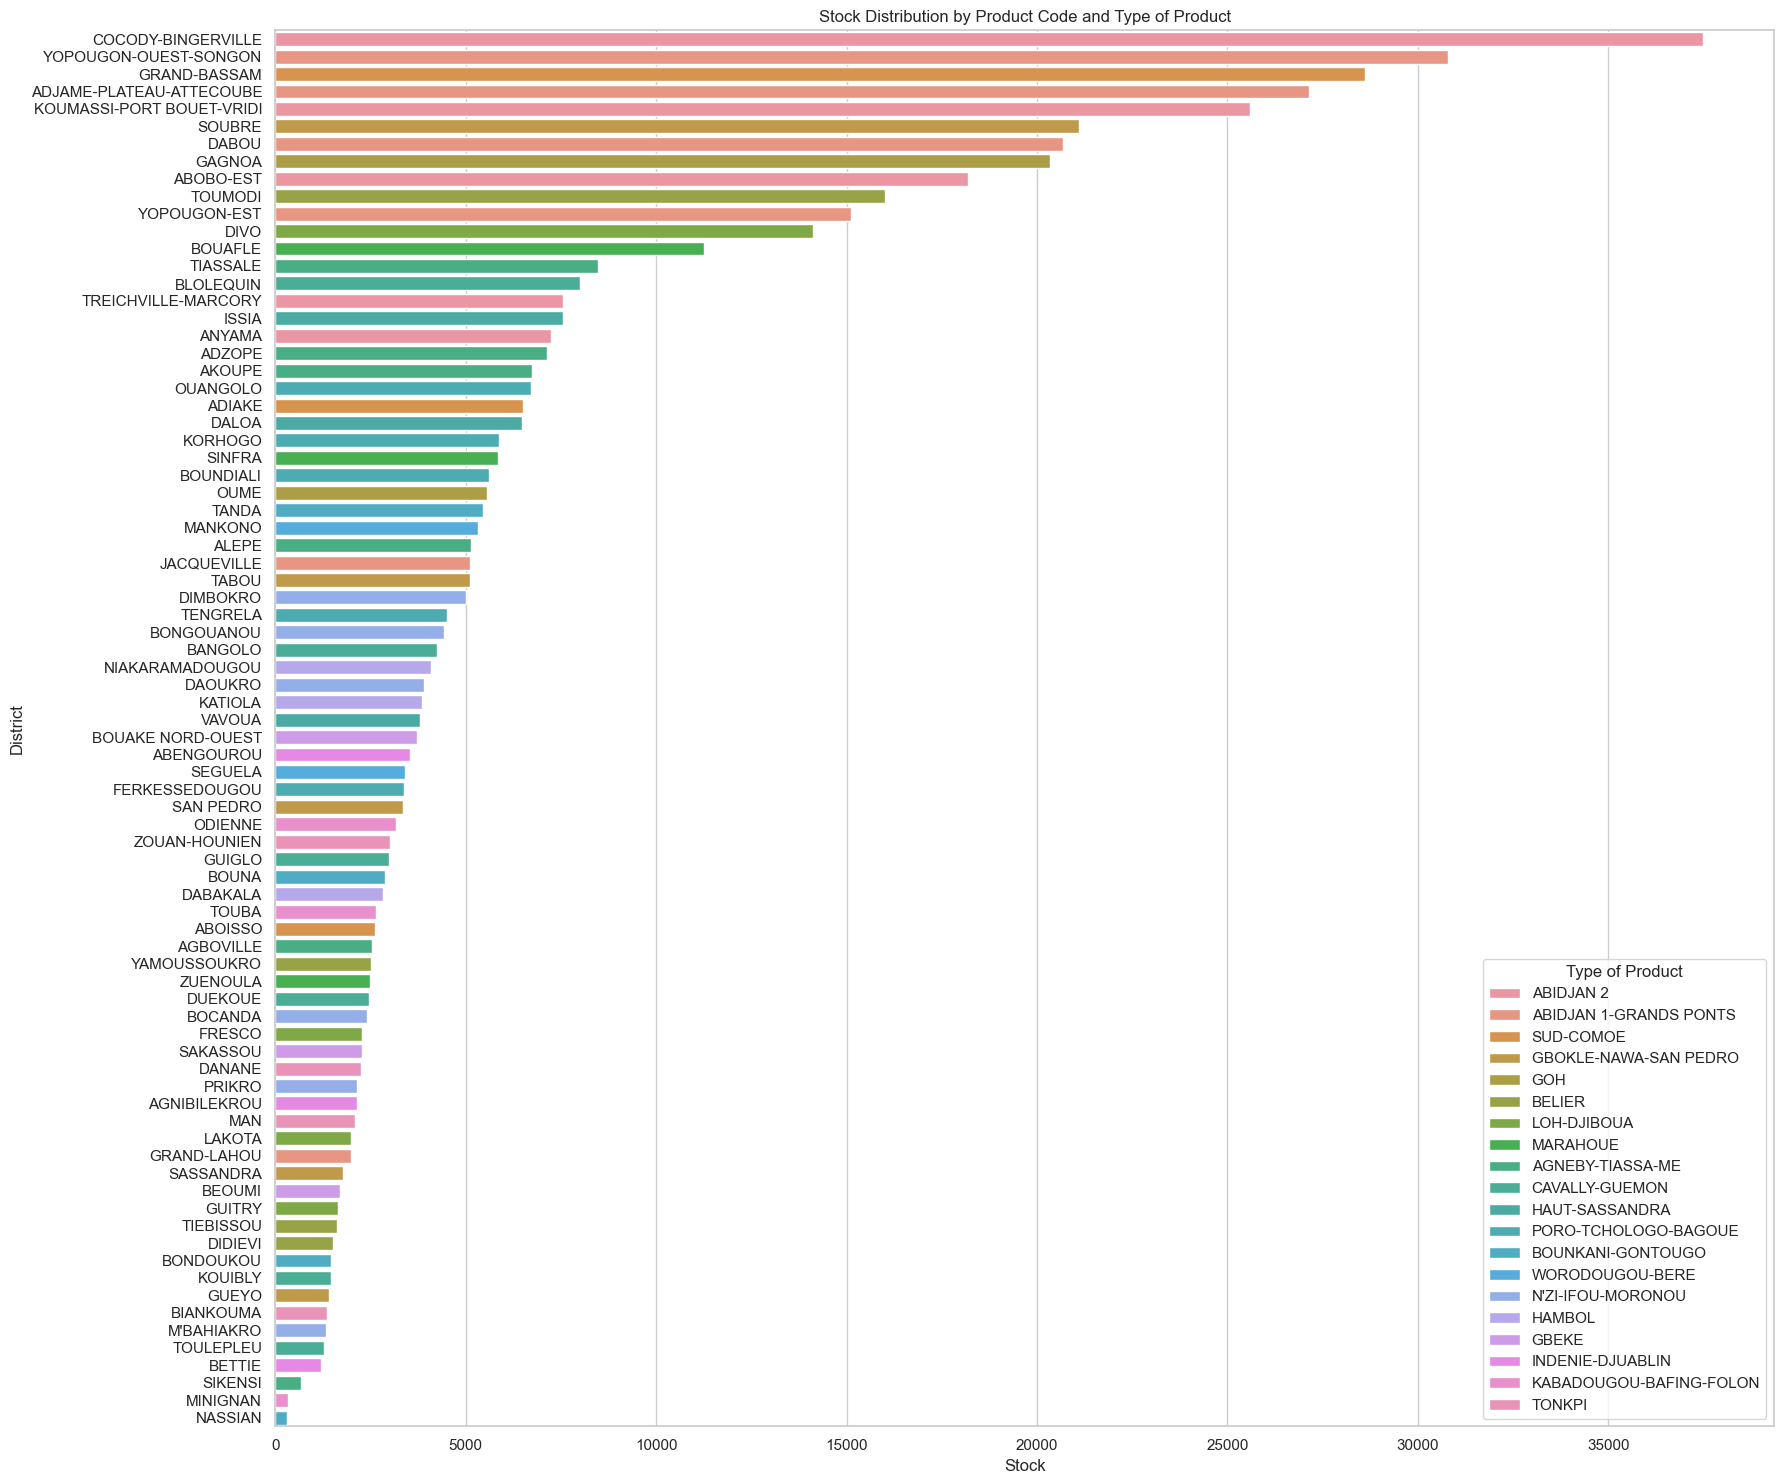

In [8]:
districts = []
stock_values = []
for district in np.unique(data.loc[:,'district']):
    data_district = data.loc[data.loc[:,'district']==district, 'stock_distributed'].sum()
    districts.append(district)
    stock_values.append(data_district)


data_plot = pd.DataFrame({'District': districts, 'Region': [district2region[district] for district in districts], 'Stock': stock_values})
data_plot_sorted = data_plot.sort_values('Stock', ascending=False)

# Plotting
plt.figure(figsize=(18, 15))
sns.barplot(x='Stock', y='District', hue='Region', data=data_plot_sorted, dodge=False)
plt.xlabel('Stock')
plt.ylabel('District')
plt.title('Stock Distribution by Product Code and Type of Product')
plt.legend(title='Type of Product')

plt.tight_layout()
plt.show()

- We see an exponential decrease for the districts.
- We see similar differences than for the regions but much more variables

### Distribution of Services sytes and Stock distributed per service site

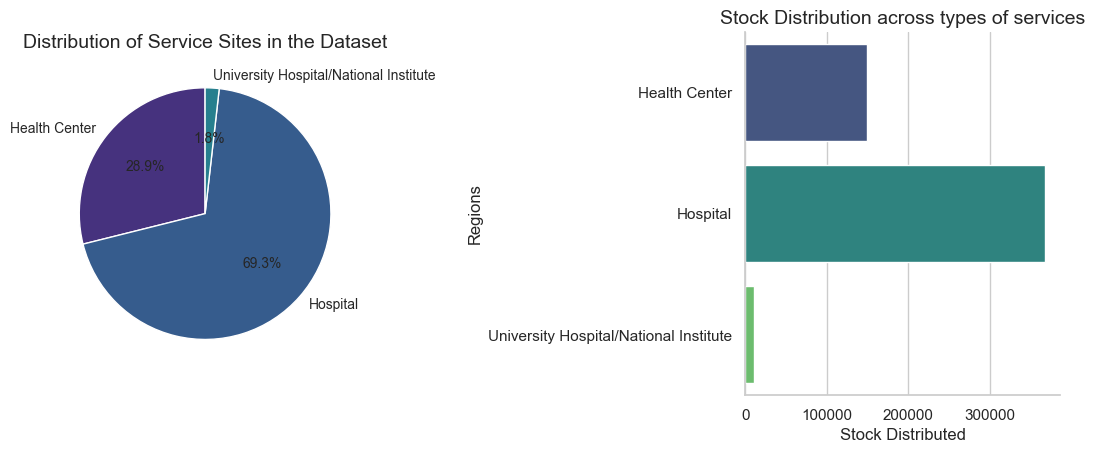

In [9]:


# Data for the pie chart
categories = np.unique(data.loc[:, 'service_type'])
counts = [data.loc[data.loc[:, 'service_type'] == service].shape[0] for service in categories]

# Data for the horizontal bar chart
sum_regions = []
for region in np.unique(data.loc[:, 'service_type']):
    sum_regions.append(data.loc[data.loc[:, 'service_type'] == region, 'stock_distributed'].sum())

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1 - Pie Chart
ax1 = axes[0]
ax1.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'),
        textprops={'fontsize': 10})  # Set font size for pie chart labels
ax1.set_title('Distribution of Service Sites in the Dataset', fontsize=14)  # Increase title font size

# Plot 2 - Horizontal Bar Chart
ax2 = axes[1]
sns.barplot(x=sum_regions, y=np.unique(data.loc[:, 'service_type']), palette='viridis', ax=ax2)
ax2.set_xlabel('Stock Distributed', fontsize=12)  # Increase x-axis label font size
ax2.set_ylabel('Regions', fontsize=12)  # Increase y-axis label font size
ax2.set_title('Stock Distribution across types of services', fontsize=14)  # Increase title font size

# Adjust spacing between subplots and overall figure aesthetics
fig.tight_layout(pad=5)  # Increase the pad parameter to adjust spacing between subplots
sns.despine()  # Remove spines from the plots

# Display the chart
plt.show()

- There are few University Hospital
- The stock distributed per service site is proportional to the proportion of each service in the region

### Visualize the time series for different products and sites

Now let's visualize the numerical continuous variables to see how they look.

For each product code and site code we have a multivariate time series with the evolution of: *stock_ordered, stock_received, stock_distributed, stock_adjustment, stock_end, average_monthly_consumption, stock_stockout_days, stock_ordered* per month. There are more than 1500 different time series.


In [10]:
from datetime import datetime
data.loc[:,'date'] = data.apply(lambda x: datetime.strptime(str(x['year'])+'-'+str(x['month']), '%Y-%m'), axis=1)


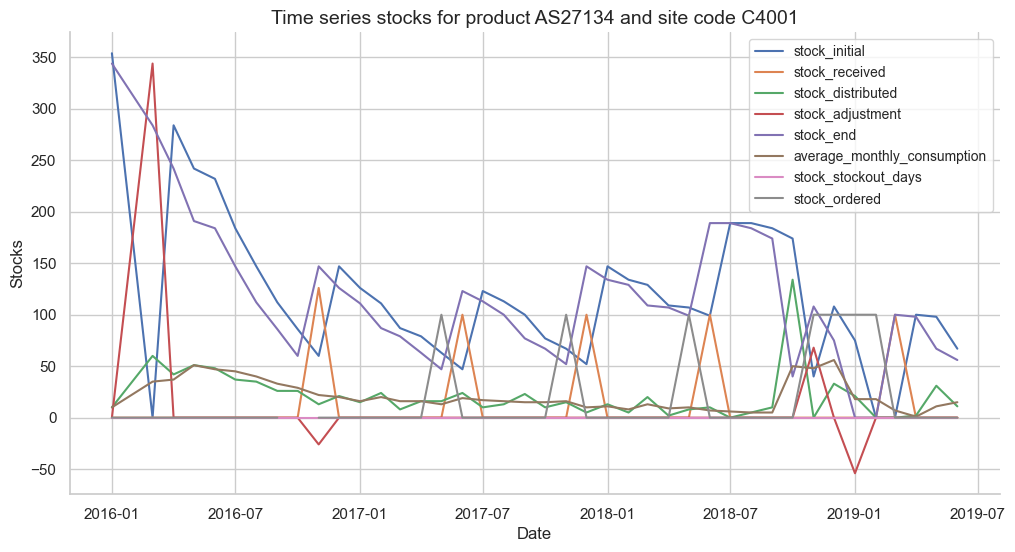

In [11]:
import plots
plots.plot_ts2(data, product='AS27134', site='C4001',cols=['stock_initial', 'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',\
                 'average_monthly_consumption', 'stock_stockout_days', 'stock_ordered'])

For example above we see the evolution for the product **AS27134** on the site code **C4001**. 

- We observe that: stock initial and stock end are almost the same time series lagged in time
- We observe also seasonality on the time series. For example the stock initial seems to have periods of 3-4 months where it increases and decreases.
- We observe that the stock distributed is similar to the *average_monthly_consumption*. In fact both variables are related. 
- It is difficult to assess relation between other variables and the stock distributed

Since it is difficult to assess visually the relation and there are many different time series let's look at the correlation of the variables:

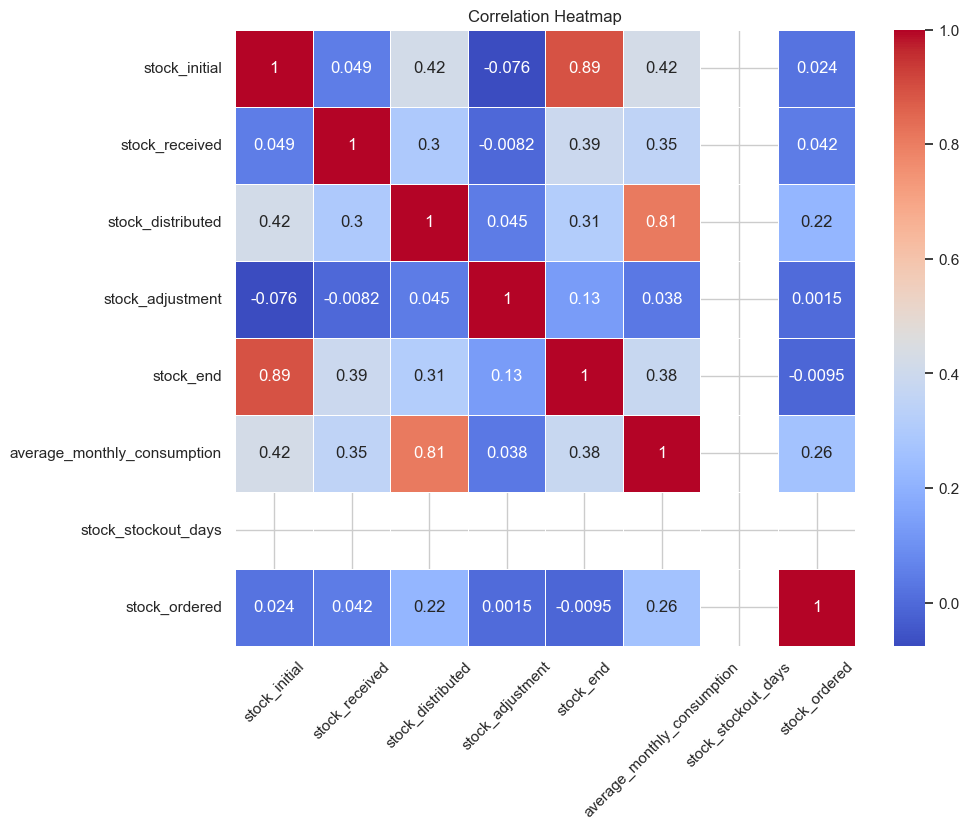

In [12]:
plots.plot_correlation_heatmap(data.loc[:,['stock_initial', 'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',\
                 'average_monthly_consumption', 'stock_stockout_days', 'stock_ordered']])

- stock_stockout_days gives NA's for all the correlations this probably means that the value of stock_ordered is always 0 and then the VAR(stock_stockout_days)=0
- The other values have all a correlation higher to 0.2
- average_monthly_consumption is by far the more related followed by stock_initial

## Null and Missing values

Let's study the missing values in the data. We will study 2 things, first how many missing values are in the dataset loaded and then how many are in the data set formatted. Many dates are missing for some products and some site codes then let's see how many

In [13]:
data.isna().sum()

year                             0
month                            0
region                           0
district                         0
site_code                        0
product_code                     0
stock_initial                    0
stock_received                   0
stock_distributed                0
stock_adjustment                 0
stock_end                        0
average_monthly_consumption      0
stock_stockout_days              0
stock_ordered                  763
service_type                     0
date                             0
dtype: int64

In the data loaded there are only 763 values missing dor stock_ordered let's study the variable

#### Let's look at the missing values for stock ordered



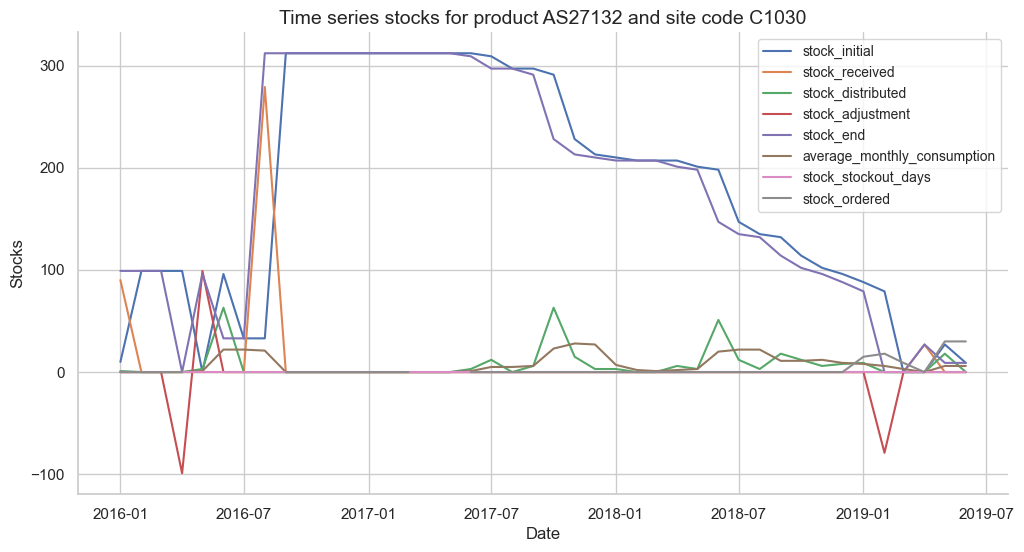

In [14]:
plots.plot_ts2(data, product='AS27132', site='C1030',cols=['stock_initial', 'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',\
                 'average_monthly_consumption', 'stock_stockout_days', 'stock_ordered'])

We chose a plot where the stock ordered has many NA's we see that the value is 0. As we can see in the cell below, it is the case for all the data. 

In [15]:
data.loc[(data.loc[:,'stock_ordered'].isna()) & (data.loc[:,'stock_ordered']>0),].shape[0]

0

### Missing dates on the data

Once we formatted the data and added the missing dates for each product_code and site_code we observed there were many missing values let's give some examples!

We will get back to the details of the format data function later.


In [16]:
data_format = preprocess.format_data(data)

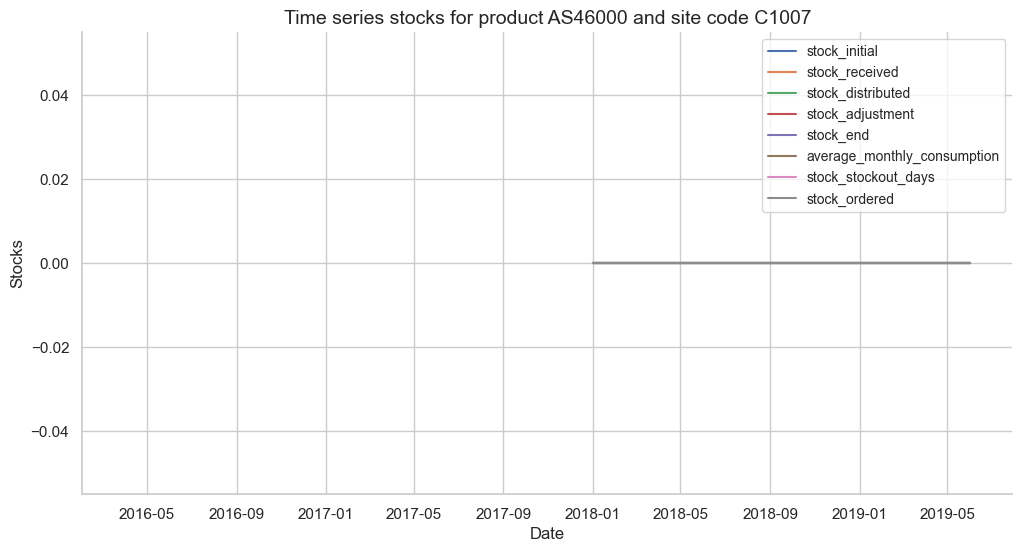

In [17]:
plots.plot_ts2(data_format, product='AS46000', site='C1007',cols=['stock_initial', 'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',\
                 'average_monthly_consumption', 'stock_stockout_days', 'stock_ordered'])

Here for example we see that the first half of the dates are missing and the second half are 0's. A common assumption would be to say that the missing values were also 0's.


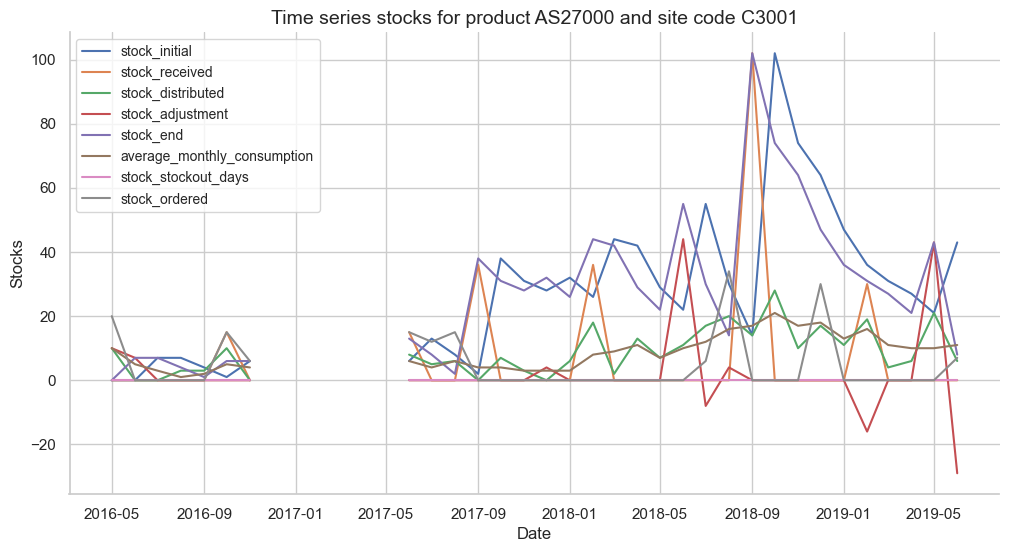

In [18]:
plots.plot_ts2(data_format, product='AS27000', site='C3001',cols=['stock_initial', 'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',\
                 'average_monthly_consumption', 'stock_stockout_days', 'stock_ordered'])

In this case we see a different scenario. The missing values are in a period in the middle and the values around are not 0. In this scenario the previous assumption does not make sense, here it would be better to do an interpolation or to propagate the last valid values forward.

By propagating the last valid values forward we have:

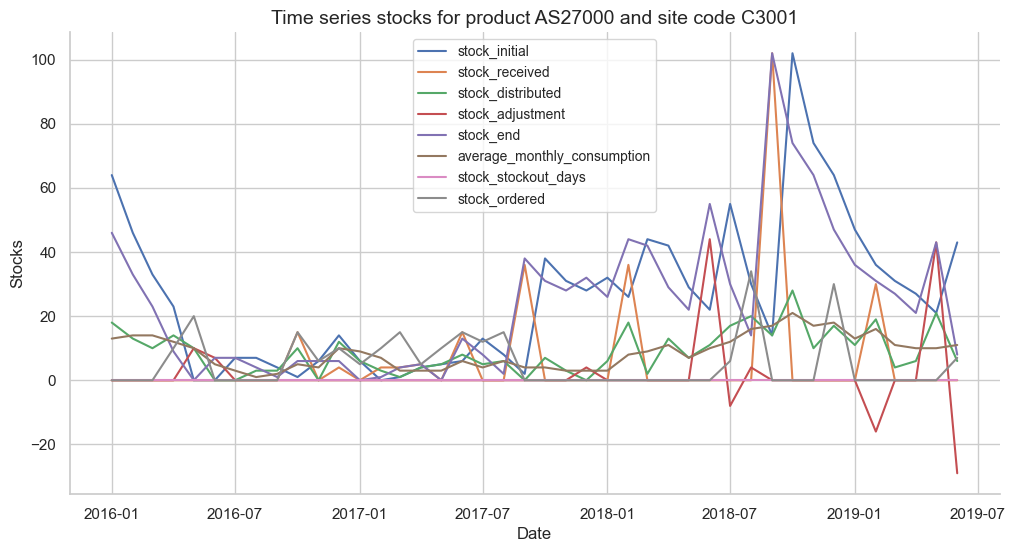

In [19]:
plots.plot_ts2(data_format.ffill(), product='AS27000', site='C3001',cols=['stock_initial', 'stock_received', 'stock_distributed', 'stock_adjustment', 'stock_end',\
                 'average_monthly_consumption', 'stock_stockout_days', 'stock_ordered'])
del data_format

Based on the exploratory analysis we decided to deal with the missing values in the following way:

- Missing values in the beginning of the time series would be filled to 0
- If a time series has less than 30 missing values then we propagate the last valid value 
- If a time series has more than 30 missing values we replace the missing values by 0

# 2. Classical Machine Learning Experiments

## Format data and eliminate NA's

In [20]:
data_format = preprocess.format_data(data)
indexes_missing_values = data_format['stock_distributed'].isnull()
data_format = preprocess.replaceNAv0(data_format)

## Split Training and Validation set

To evaluate the model we decided to go for the method of splitting the data in a training and validation set, and we decided to pick the last 4 months as the months to evaluate the data. The reasons:

- It is a similar scenario to the test set.
- Cross validation is more time consuming, and we want a common method for all of our models and some models (NN) would take too much time.
- Since some of the feature are lags it was simpler to do it in this way.



In [21]:
TRAIN_START_MONTH = '2016-03-01' # Train Data Using Data 6 Months after the First Data Recorded
TRAIN_END_MONTH = '2019-02-01'

VAL_START_MONTH = '2019-03-01' # Test Data Using Last 2 Month Data
VAL_END_MONTH = '2019-06-01'

## Experiment 1:

Let's do our first experiment for predicting the stock_distributed:

The objective of the experiment is to see:

- Is it best a standard scaler or a robust scaler
- What are the metrics for the model
- Is it better to choose region or district :In the EDA we saw that both variables were giving similar information, district was giving more but there were also much more districts than regions.

For this experiment we will fit 3 Linear regressions and the features will be:

For the first one the feature are:

We will scale the numerical variable in a standard way by substracting the mean and dividing by the standard deviation

- Numerical: stock_distributed_lag_1 -> this feature is the value of the previous month of stock distributed.
- Categorical: 'month','region','product_code', 'site_code', 'service_type', 'product_type'.

We decided to include month since in the EDA we saw some seasonality. 

For the second logistic regression features will be the same but we will use a robust scaler to scale the numerical variables that scales with the median and quantiles that are more robust to outliers

For the third logistic regression we use the robust scaler but with district instead of region

The equation of the Logistic regression will be something like

$$f(X) = \beta_1\times stockDistributed + \beta_{siteCode_1} \times isSiteCode_1 + ... + \beta_{siteCode_{155}}\times isSiteCode_{155} + \beta_{month_1}\times isMonth_1 + .... + \beta_{month_{12}}\times isMonth_{12} + ......  $$


In [22]:
for i in range(1,2):
    data_format[f'stock_distributed_lag_{i}'] = data_format.groupby(['site_code', 'product_code'])['stock_distributed'].shift(i)

numerical_features = ['stock_distributed_lag_1']
categorical_features = ['month','region', 'product_code','site_code', 'service_type', 'product_type']
categorical_features_2 = ['month','district','product_code', 'site_code', 'service_type', 'product_type']

target = ['stock_distributed']

In [23]:
train = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(TRAIN_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(TRAIN_END_MONTH, '%Y-%m-%d')), ]


val = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(VAL_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(VAL_END_MONTH, '%Y-%m-%d')), ]

val_nona = val.loc[indexes_missing_values[val.index[0]:]==False,]

In [24]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



X_train = train[numerical_features+categorical_features]
X_train2= train[numerical_features+categorical_features_2]

y_train = train[target]


X_val = val[numerical_features+categorical_features]
X_val2 = val[numerical_features+categorical_features_2]
y_val = val[target]

# Create the preprocessing transformers
cat_transformer = OneHotEncoder()
num_transformer = MinMaxScaler()

# Create the column transformer
preprocessor1 = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features),
    ('num', RobustScaler(), numerical_features)
])

preprocessor2 = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

preprocessor3 = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features_2),
    ('num', StandardScaler(), numerical_features)
])

# Create the pipeline

models = {}

models['LR1'] = Pipeline([
    ('preprocessor', preprocessor1),
    ('regressor', LinearRegression())
])

models['LR2'] = Pipeline([
    ('preprocessor', preprocessor2),
    ('regressor', LinearRegression())
])

models['LR_district'] = Pipeline([
    ('preprocessor', preprocessor3),
    ('regressor', LinearRegression())
])

# Fit the pipeline
for name, reg in tqdm(models.items()):
    if name!='LR_district':
        reg.fit(X_train, y_train['stock_distributed'].values)
    else:
        reg.fit(X_train2, y_train['stock_distributed'].values)


100%|██████████| 3/3 [00:00<00:00,  9.71it/s]


### Evaluation

For the evaluation we created the function:

- predict_sklearn_pipeline that can be found in the [models_](/src/models_.py) script.

This function updates the prediction of the lagged variables for the following months, for example if we have the features *stock_distributed_lag_1* and *stock_end_lag_2*
Then the prediction for stock_distributed will replace the 2nd month of sock_distributed_lag1 and the prediction of stock_end will replace the 3rd month of stock_end_lag_2

We did this since for the test set we will only know the value of the lagged variables for the first month and we want the evaluation to give us an idea on how well we can do on the submission

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score,explained_variance_score, max_error

print('|Model|MSE|mean absolute error|median absolute error| R2 score|')
print('|:----:|:----:|:--------:|:--------------:|:-------:|')
for name, reg in models.items():
    if name != 'LR_district':
        y_pred = predict_sklearn_pipeline(reg, val, 'stock_distributed_lag_1', numerical_features+categorical_features, 'stock_distributed')
    else:
        y_pred = predict_sklearn_pipeline(reg, val, 'stock_distributed_lag_1', numerical_features+categorical_features_2, 'stock_distributed')
    y_pred = np.where(y_pred<0, 0, y_pred)
    metrics = []
    for metric in [mean_squared_error,mean_absolute_error, median_absolute_error, r2_score]:
        metrics.append(metric(y_val["stock_distributed"].values, y_pred))
    print(f'|{name}|{metrics[0]:.02f}|{metrics[1]:.02f}|{metrics[2]:.02f}|{metrics[3]:.02f}|')

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR1|545.98|9.39|3.00|0.32|
|LR2|545.99|9.39|3.00|0.32|
|LR_district|545.99|9.39|3.00|0.32|


### Results

First we can see clearly see that it make sense to update the lagged variables since the performance differs:

Results without updating the lagged values in the validation set:

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR1|452.75|8.42|3.10|0.44|
|LR2|452.75|8.42|3.09|0.44|

Results updating the lagged values in the validation set:

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR1|545.06|9.71|3.66|0.32|
|LR2|545.07|9.71|3.66|0.32|
|LR_district|545.07|9.71|3.66|0.32|


All the logistic regression perform very similar. We see that the median absolute erros is much smaller than the mean absolute error which suggests that they might be outliers in the errors that affect to this.

As conclusions:

- We will add regions instead of district since the performance is the model with regions is less complex (less variables)
- We willc go for the Robust scaler, the performance is similar but is more robust to outliers


## Experiment 2

In this ecperiment we add a numerical variable and we fit different models.

Our features will be:

- numerical_features: 'stock_distributed_lag_1', 'stock_distributed_lag_2' -> We add another lag of the target to see if it increases the performance
- categorical_features: 'month','product_code', 'site_code', 'service_type', 'product_type'

This time we fit a Linear Regression a Random Forest and Gradient Boosting.

In [26]:
for i in range(1,3):
    data_format[f'stock_distributed_lag_{i}'] = data_format.groupby(['site_code', 'product_code'])['stock_distributed'].shift(i)

numerical_features = ['stock_distributed_lag_1', 'stock_distributed_lag_2']
categorical_features = ['region','month','product_code', 'site_code', 'service_type', 'product_type']

target = ['stock_distributed']

In [27]:
train = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(TRAIN_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(TRAIN_END_MONTH, '%Y-%m-%d')), ]


val = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(VAL_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(VAL_END_MONTH, '%Y-%m-%d')), ]

val_nona = val.loc[indexes_missing_values[val.index[0]:]==False,]

X_train = train[numerical_features+categorical_features]
y_train = train[target]


X_val = val[numerical_features+categorical_features]
y_val = val[target]


In [28]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features),
    ('num', RobustScaler(), numerical_features)
])

models = {}

models['LR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

models['RFR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

models['GBR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

# Fit the pipeline
for name, reg in tqdm(models.items()):
    reg.fit(X_train, y_train['stock_distributed'].values)


print('|Model|MSE|mean absolute error|median absolute error| R2 score|')
print('|:----:|:----:|:--------:|:--------------:|:-------:|')
for name, reg in models.items():
    y_pred = reg.predict(X_val)
    y_pred = np.where(y_pred<0, 0, y_pred)
    metrics = []
    for metric in [mean_squared_error,mean_absolute_error, median_absolute_error, r2_score]:
        metrics.append(metric(y_val["stock_distributed"].values, y_pred))
    print(f'|{name}|{metrics[0]:.02f}|{metrics[1]:.02f}|{metrics[2]:.02f}|{metrics[3]:.02f}|')

100%|██████████| 3/3 [01:30<00:00, 30.20s/it]

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|397.03|7.32|1.96|0.50|
|RFR|424.81|6.70|0.00|0.47|
|GBR|389.12|6.77|1.23|0.51|


|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|398.68|7.64|2.58|0.51|
|RFR|463.07|7.03|0.08|0.43|
|GBR|416.98|7.14|1.77|0.48|

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score,explained_variance_score, max_error

print('|Model|MSE|mean absolute error|median absolute error| R2 score|')
print('|:----:|:----:|:--------:|:--------------:|:-------:|')
for name, reg in models.items():
    y_pred = predict_sklearn_pipeline(reg, val, numerical_features, numerical_features+categorical_features, 'stock_distributed')
    y_pred = np.where(y_pred<0, 0, y_pred)
    metrics = []
    for metric in [mean_squared_error,mean_absolute_error, median_absolute_error, r2_score]:
        metrics.append(metric(y_val["stock_distributed"].values, y_pred))
    print(f'|{name}|{metrics[0]:.02f}|{metrics[1]:.02f}|{metrics[2]:.02f}|{metrics[3]:.02f}|')

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|480.85|8.80|2.76|0.40|
|RFR|511.53|7.69|0.00|0.36|
|GBR|504.83|8.40|2.49|0.37|


## Results

Without updating lags in the validation set:

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|396.95|7.53|2.34|0.50|
|RFR|429.91|6.92|0.15|0.46|
|GBR|397.95|6.96|2.13|0.50|


Updating the lags in the validation set:

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|481.11|9.09|3.25|0.40|
|RFR|502.15|7.94|0.33|0.37|
|GBR|518.44|7.96|2.28|0.35|


- The best MSE were achieved by the linear regression
- However the Random Forest has a median absolute error that is extremely low. For 50% of the points in the validation set the error is less than 0.18
- Since the MSE of the logistic regression is smaller it suggests that in the 50% were the errors are bigger the LR performs better
- For the mean absolute error the random forest has the best results
- The logistic regression is the model that explains more variance of the target.


## Experiment 3

In this experiment we will now add the other numerical variables to see how the model performs. Since we don't know the value of the other variables in the test set our model then has to be a multivariate regression model that aims to predict all the numerical variables.

- numerical_variables: 'stock_distributed_lag_1', 'stock_distributed_lag_2', 'stock_initial_lag_1', 'stock_received_lag_1', 'stock_adjustment_lag_1', 'stock_end_lag_1', 'average_monthly_consumption_lag_1', 'stock_ordered_lag_1'
- categorical_features: 'month','region','product_code', 'site_code', 'service_type', 'product_type'
- target: 'stock_distributed','stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 'average_monthly_consumption', 'stock_ordered'

This time we will fit a Logistic regression and a Random forest

The idea is to compare the resulting model to the previous one

In [30]:
for cat_numerical in ['stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 'average_monthly_consumption', 'stock_ordered']:
    for i in range(1,2):
        data_format[f'{cat_numerical}_lag_{i}'] = data_format.groupby(['site_code', 'product_code'])[cat_numerical].shift(i)


numerical_features = ['stock_distributed_lag_1', 'stock_distributed_lag_2']

for cat_numerical in ['stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 
                'average_monthly_consumption', 'stock_ordered']:
    for i in range(1,2):
        numerical_features.append(f'{cat_numerical}_lag_{i}')

categorical_features = ['month','region','product_code', 'site_code', 'service_type', 'product_type']

target = ['stock_distributed'] + ['stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 'average_monthly_consumption', 'stock_ordered']

In [31]:
def add_features(data):
    for i in range(1,3):
        data[f'stock_distributed_lag_{i}'] = data.groupby(['site_code', 'product_code'])['stock_distributed'].shift(i)

    for cat_numerical in ['stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 'average_monthly_consumption', 'stock_ordered']:
        for i in range(1,2):
            data[f'{cat_numerical}_lag_{i}'] = data.groupby(['site_code', 'product_code'])[cat_numerical].shift(i)
    return data

In [32]:
train = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(TRAIN_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(TRAIN_END_MONTH, '%Y-%m-%d')), ]


val = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(VAL_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(VAL_END_MONTH, '%Y-%m-%d')), ]

val_nona = val.loc[indexes_missing_values[val.index[0]:]==False,]

X_train = train[numerical_features+categorical_features]
y_train = train[target]


X_val = val[numerical_features+categorical_features]
y_val = val[target]


In [33]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', RobustScaler(), numerical_features)
])

models = {}

models['LR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


models['RFR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

"""
models['GBR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])
"""

# Fit the pipeline
for name, reg in tqdm(models.items()):
    reg.fit(X_train, y_train.loc[:,target].values)


print('|Model|MSE|mean absolute error|median absolute error| R2 score|')
print('|:----:|:----:|:--------:|:--------------:|:-------:|')
for name, reg in models.items():
    y_pred = reg.predict(X_val)[:,0]
    y_pred = np.where(y_pred<0, 0, y_pred)
    metrics = []
    for metric in [mean_squared_error,mean_absolute_error, median_absolute_error, r2_score]:
        metrics.append(metric(y_val["stock_distributed"].values, y_pred))
    print(f'|{name}|{metrics[0]:.02f}|{metrics[1]:.02f}|{metrics[2]:.02f}|{metrics[3]:.02f}|')

100%|██████████| 2/2 [02:54<00:00, 87.49s/it] 


|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|335.85|6.62|1.12|0.58|
|RFR|339.32|5.92|0.03|0.57|


|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|343.08|6.80|1.38|0.58|
|RFR|327.43|6.02|0.10|0.59|

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score,explained_variance_score, max_error

print('|Model|MSE|mean absolute error|median absolute error| R2 score|')
print('|:----:|:----:|:--------:|:--------------:|:-------:|')
for name, reg in models.items():
    y_pred = predict_sklearn_pipeline(reg, val, numerical_features, numerical_features+categorical_features, target)
    y_pred = np.where(y_pred<0, 0, y_pred)
    metrics = []
    for metric in [mean_squared_error,mean_absolute_error, median_absolute_error, r2_score]:
        metrics.append(metric(y_val["stock_distributed"].values, y_pred[:,0]))
    print(f'|{name}|{metrics[0]:.02f}|{metrics[1]:.02f}|{metrics[2]:.02f}|{metrics[3]:.02f}|')

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|407.33|7.48|1.65|0.49|
|RFR|387.82|6.87|0.18|0.51|


## Results

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|LR|407.33|7.48|1.65|0.49|
|RFR|381.69|6.79|0.14|0.52|


The best results were obtained on the Random Forest for this experiment. The mean absolute error decrease, the MSE decreased a lot and the R2 is much better.

The random forest surpases the logistic regression in all the metrics



# 3. Neural Network Forecasting

The last experiment is to fit a neural network to the data.

We builded a Fully Connected neural network. We treated the continuous variables and categorical in a separated way as suggested in: https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F

In [36]:
CONFIG = {
    'BATCH_SIZE': 64,
    'EPOCHS':1000,
    'lr':1e-2,
}

In [37]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for cat_col in categorical_features:
    label_encoders[cat_col] = LabelEncoder()
    data_format[cat_col] = label_encoders[cat_col].fit_transform(data_format[cat_col])

In [38]:
from datetime import datetime

train = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(TRAIN_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(TRAIN_END_MONTH, '%Y-%m-%d')), ]


val = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(VAL_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(VAL_END_MONTH, '%Y-%m-%d')), ]

In [39]:
train_dataset = models_.ContraceptiveDataset(data=train, cat_cols=categorical_features, cont_cols=numerical_features, output_col=target)
val_dataset = models_.ContraceptiveDataset(data=val, cat_cols=categorical_features, cont_cols=numerical_features, output_col=target)


For chosing the size of the embeddings we rely on what I read on different blogs

In [40]:
cat_dims = [int(data_format[col].nunique()) for col in categorical_features]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [41]:
model = models_.FeedForwardNN(emb_dims, num_cont=len(numerical_features), lin_layer_sizes=[50, 100],
                          output_size=len(target), emb_dropout=0.1,
                          lin_layer_dropouts=[0.1,0.1])

In [42]:
train_loader = DataLoader(train_dataset, CONFIG['BATCH_SIZE'], shuffle=True)

In [43]:
no_of_epochs = CONFIG['EPOCHS']
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])
for epoch in range(no_of_epochs):
    running_loss = 0.0
    num_batches = 0
    for y, cont_x, cat_x in train_loader:
      
        cat_x = cat_x
        cont_x = cont_x
        y  = y

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)

        

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    if (epoch+1)%10==0:
        print(f'For epoch {epoch+1} the loss is {running_loss/num_batches}')

For epoch 10 the loss is 2497.4119983990986
For epoch 20 the loss is 2367.778196811676
For epoch 30 the loss is 2323.9055560588836
For epoch 40 the loss is 2259.0318084081014
For epoch 50 the loss is 2277.6306007703147
For epoch 60 the loss is 2219.977425861359
For epoch 70 the loss is 2239.68112505277
For epoch 80 the loss is 2217.045289214452
For epoch 90 the loss is 2284.017709525426
For epoch 100 the loss is 2191.7868319829304
For epoch 110 the loss is 2219.6531813939414
For epoch 120 the loss is 2183.5728712240857
For epoch 130 the loss is 2184.0151818911236
For epoch 140 the loss is 2162.757296657562
For epoch 150 the loss is 2114.30173851649
For epoch 160 the loss is 2073.444273964564
For epoch 170 the loss is 2110.948205916087
For epoch 180 the loss is 2180.737240886688
For epoch 190 the loss is 2090.8353600343066
For epoch 200 the loss is 2101.4401775836945
For epoch 210 the loss is 2099.2254417737327
For epoch 220 the loss is 2143.079307858149
For epoch 230 the loss is 2051.4

In [59]:
output = model(torch.tensor(val_dataset.cont_X), torch.tensor(val_dataset.cat_X))
y_pred_stock = output[:,0].detach().numpy()
y_target_stock = val_dataset.y[:,0]
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, max_error, explained_variance_score

print()
metrics = []

print('|Model|MSE|mean absolute error|median absolute error| R2 score|')
print('|:----:|:----:|:--------:|:--------------:|:-------:|')
for metric in [mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score, max_error]:
    metrics.append(metric(y_target_stock, y_pred_stock))
print(f'|NN|{metrics[0]:.02f}|{metrics[1]:.02f}|{metrics[2]:.02f}|{metrics[3]:.02f}|')


|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|NN|1094.88|9.67|4.27|-0.37|


## Results

The results of the NN are:

|Model|MSE|mean absolute error|median absolute error| R2 score|
|:----:|:----:|:--------:|:--------------:|:-------:|
|NN|1094.88|9.67|4.27|-0.37|



## Train best model whole dataset

Let's train the best model in the whole dataset

In [90]:
for cat_numerical in ['stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 'average_monthly_consumption', 'stock_ordered']:
    for i in range(1,2):
        data_format[f'{cat_numerical}_lag_{i}'] = data_format.groupby(['site_code', 'product_code'])[cat_numerical].shift(i)


numerical_features = ['stock_distributed_lag_1', 'stock_distributed_lag_2']

for cat_numerical in ['stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 
                'average_monthly_consumption', 'stock_ordered']:
    for i in range(1,2):
        numerical_features.append(f'{cat_numerical}_lag_{i}')

categorical_features = ['month','region','product_code', 'site_code', 'service_type', 'product_type']

target = ['stock_distributed'] + ['stock_initial', 'stock_received', 'stock_adjustment', 'stock_end', 'average_monthly_consumption', 'stock_ordered']

In [93]:
train = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(TRAIN_START_MONTH, '%Y-%m-%d')), ]

X_train = train[numerical_features+categorical_features]
y_train = train[target]



preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', RobustScaler(), numerical_features)
])

models = {}


model_final = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])


model_final.fit(X_train, y_train.loc[:,target].values)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'region',
                                                   'product_code', 'site_code',
                                                   'service_type',
                                                   'product_type']),
                                                 ('num', RobustScaler(),
                                                  ['stock_distributed_lag_1',
                                                   'stock_distributed_lag_2',
                                                   'stock_initial_lag_1',
                                                   'stock_received_lag_1',
                                                   'stock_adjustment_lag_1',
                                                   'stock_end_lag_1',
                                                   'average_monthly_consumption_lag_1',
                                                   'stock_ordered_lag_1'])])),
                ('regressor', RandomForestRegressor())])

### Save Model

In [95]:
import pickle
PATH_MODELS = join(PATH_REPO, 'models')

pickle.dump(model_final, open(join(PATH_MODELS, 'random_forest_contraceptive.sav'), 'wb'))